# Metran practical example

This notebook shows a practical application of Metran on calculated residuals from univariate time series models as published in the article [van Geer and Berendrecht in Stromingen (2015)](#References).

In [1]:
import os
import pandas as pd
import metran

## Read example data

Read residuals from time series analysis models for 5 piezometers at different depths at location B21B0214. (The time series models are not shown here, only the resulting residuals.)

In [2]:
residuals = {}
rfiles = [os.path.join("./data", f) for f in os.listdir("./data") if f.endswith("_res.csv")]

for fi in rfiles:
    name = fi.split(os.sep)[-1].split(".")[0].split("_")[0]
    ts = pd.read_csv(fi, header=0, index_col=0, parse_dates=True, 
                     infer_datetime_format=True,dayfirst=True)
    residuals[name] = ts

In [3]:
# sort names (not necessary, but ensures the order of things)
sorted_names = list(residuals.keys())
sorted_names.sort()
sorted_names

['B21B0214001', 'B21B0214002', 'B21B0214003', 'B21B0214004', 'B21B0214005']

## Create Metran model

First collect series in a list with their unique IDs.

In [4]:
series = []

for name in sorted_names:
    ts = residuals[name]
    ts.columns = [name]
    series.append(ts)

Create the Metran model and solve.

In [5]:
mt = metran.Metran(series, name="B21B0214")
mt.solve()

INFO: Number of factors according to Velicer's MAP test: 1



Fit report B21B0214        Fit Statistics
tmin     None             obj     2332.33
tmax     None             nfev    77
freq     D                AIC     2344.33
solver   ScipySolve               

Parameters (6 were optimized)
              optimal   stderr initial  vary
sdf1_alpha   5.500952  ±19.06%      10  True
sdf2_alpha  13.559921   ±9.99%      10  True
sdf3_alpha   4.682783  ±28.90%      10  True
sdf4_alpha  11.381772  ±18.15%      10  True
sdf5_alpha  13.140258   ±8.44%      10  True
cdf1_alpha  22.981099   ±7.44%      10  True

Parameter correlations |rho| > 0.5
None

Metran report B21B0214       Factor Analysis
tmin     None                nfct    1
tmax     None                fep     88.32%
freq     D                            

State parameters
                  phi         q
sdf1         0.833779  0.080430
sdf2         0.928907  0.017024
sdf3         0.807713  0.023102
sdf4         0.915889  0.013316
sdf5         0.926722  0.026608
cdf1         0.957419  0.083349

Obs

## Visualizing and accessing Metran results

The results of the Metran can be visualized using the `Metran.plots` class.

### Scree plot

We can draw a scree plot to visualize the eigenvalues (used in determining the number of factors).

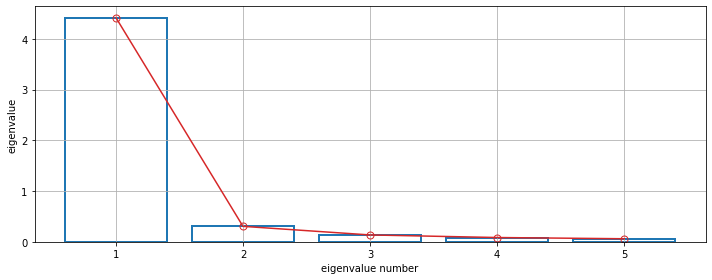

In [6]:
# Plot eigenvalues in scree plot, see e.g. Fig 2 in JoH paper
ax = mt.plots.scree_plot()

### State means

Plot the calculated state means for each of the specific and common dynamic components:

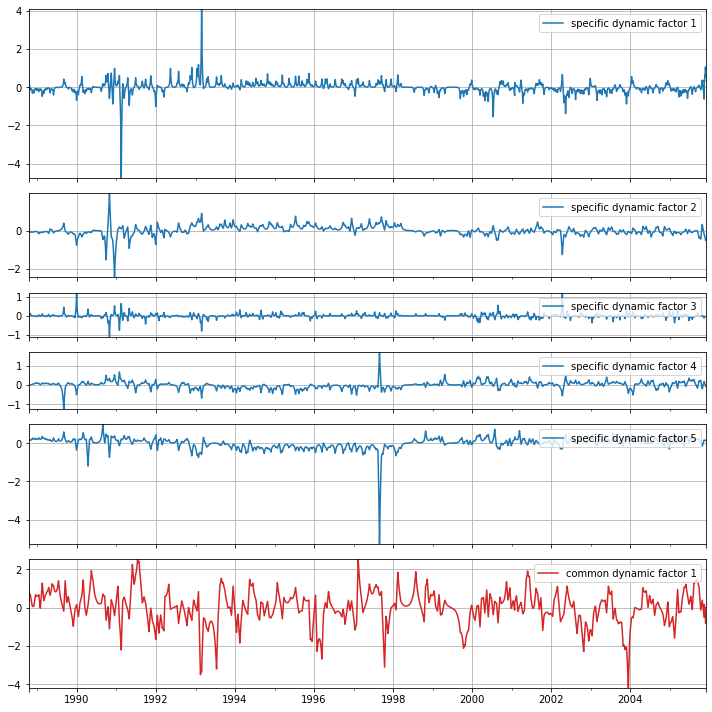

In [7]:
axes = mt.plots.state_means(adjust_height=True)

### Simulations


The simulated mean values for each time series in our Metran model can be obtained with:

In [8]:
# Get all (smoothed) projected state means
means = mt.get_simulated_means()
means.head(10)

,B21B0214001,B21B0214002,B21B0214003,B21B0214004,B21B0214005
date,,,,,
1988-10-14,5.450000,4.280000,4.620000,4.640000,5.480000
1988-10-15,5.094120,4.132050,4.500648,4.514892,5.348732
1988-10-16,4.781724,3.992289,4.396365,4.399177,5.231282
1988-10-17,4.505267,3.860282,4.306656,4.292538,5.127357
1988-10-18,4.258162,3.735611,4.231337,4.194680,5.036710
1988-10-19,4.034570,3.617872,4.170536,4.105330,4.959140
1988-10-20,3.829207,3.506670,4.124709,4.024232,4.894491
1988-10-21,3.637173,3.401624,4.094661,3.951152,4.842651
1988-10-22,3.453797,3.302358,4.081594,3.885873,4.803553


For obtaining the data for a simulation with the observations and an (optional) confidence interval, use `mt.get_simulation()`.

In [13]:
# Get simulated mean for specific series with/without confidence interval
name = "B21B0214005"
sim = mt.get_simulation(name, alpha=0.05)
sim.head(10)

,mean,lower,upper
date,,,
1988-10-14,5.480000,5.480000,5.480000
1988-10-15,5.348732,1.669951,9.027513
1988-10-16,5.231282,0.273549,10.189015
1988-10-17,5.127357,-0.640244,10.894958
1988-10-18,5.036710,-1.263485,11.336905
1988-10-19,4.959140,-1.669240,11.587520
1988-10-20,4.894491,-1.891050,11.680031
1988-10-21,4.842651,-1.942753,11.628054
1988-10-22,4.803553,-1.824445,11.431552


There is also a method to visualize these results for a single timeseries including optional confidence interval:

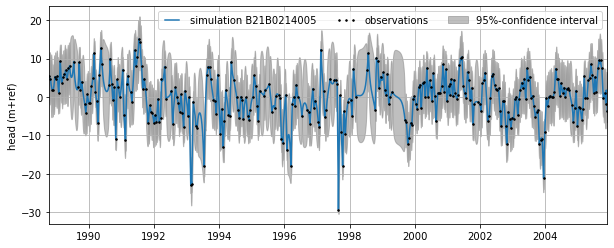

In [10]:
ax = mt.plots.simulation("B21B0214005", alpha=0.05)

Or all for all timeseries:

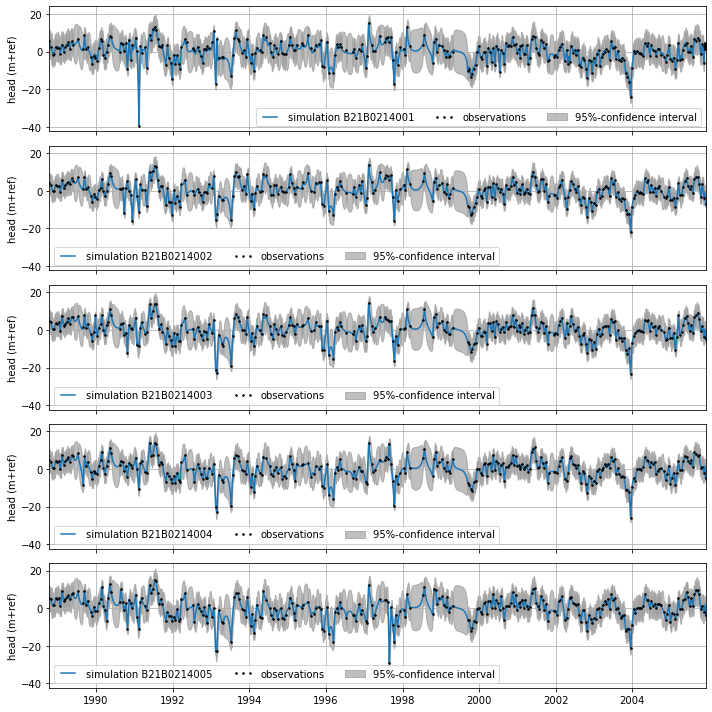

In [11]:
axes = mt.plots.simulations(alpha=0.05)

### Decompositions

The decomposition of a simulation into specific and common dynamic components can be obtained with `mt.decompose_simulation()`.

In [14]:
# Decomposed simulated mean for specific series
decomposition = mt.decompose_simulation("B21B0214001")
decomposition.head(10)

,sdf,cdf1
date,,
1988-10-14,1.339357,4.110643
1988-10-15,1.080935,4.013186
1988-10-16,0.858395,3.923329
1988-10-17,0.664365,3.840902
1988-10-18,0.492413,3.765749
1988-10-19,0.336843,3.697727
1988-10-20,0.192499,3.636708
1988-10-21,0.054597,3.582576
1988-10-22,-0.081431,3.535228


This can also be visualized:

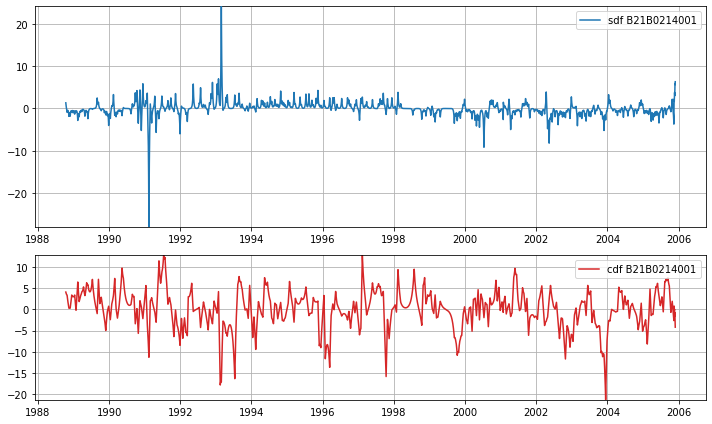

In [13]:
axes = mt.plots.decomposition("B21B0214001", split=True, adjust_height=True)

Or for all timeseries

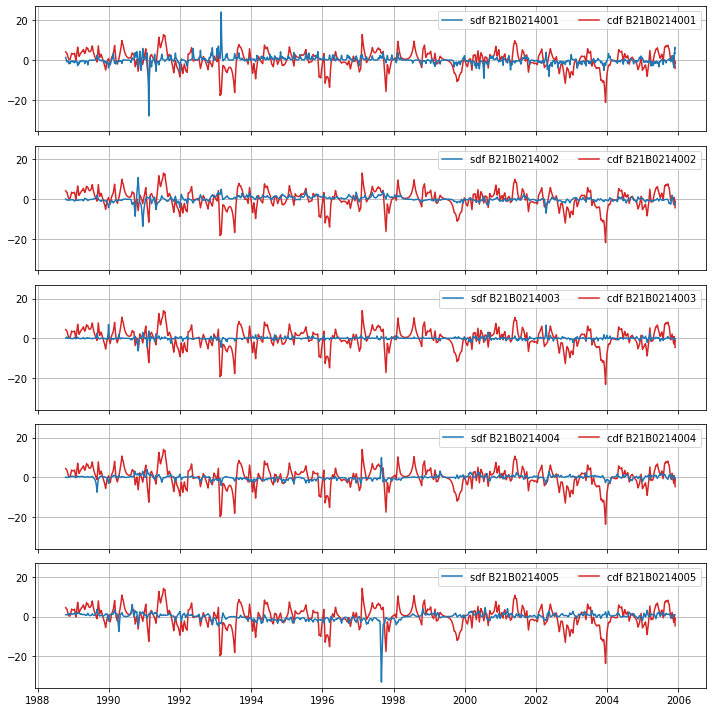

In [14]:
axes = mt.plots.decompositions()

## Example application: removing outliers

The Kalman smoother can be re-run after removing (masking) outliers from the observations. This is illustrated below.

First plot the simulation for the original data:

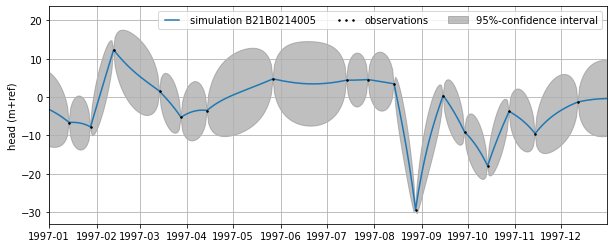

In [20]:
name = "B21B0214005"
alpha = 0.05

ax1 = mt.plots.simulation(name, alpha=alpha, tmin="1997-01-01", tmax="1997-12-31")

Mask (remove) the outlier on 28 august 1997.

In [21]:
oseries = mt.get_observations()
mask = (0 * oseries).astype(bool)
mask.loc["1997-8-28", name] = True
mt.mask_observations(mask)

Now plot the simulation again. Note the estimated value and its 95%-confidence interval for the observation on 28 August 1997 based on the common dynamic factor.

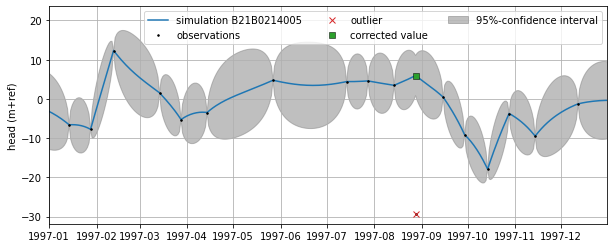

In [31]:
# remove outlier from series B21B0214005 at 1997-8-28
# and re-run smoother to get estimate of observation
# (Fig 3 in Stromingen without deterministic component)
ax2 = mt.plots.simulation(name, alpha=alpha, tmin="1997-01-01", tmax="1997-12-31")
sim = mt.get_simulation(name, alpha=None).loc[["1997-8-28"]]

# plot outlier and corrected value
outlier = oseries.loc[["1997-8-28"], name]
ax2.plot(outlier.index, outlier, "C3x", label="outlier")
ax2.plot(sim.index, sim, "C2s", label="corrected value", mec="k", mew=0.5)
ax2.legend(loc="best", ncol=3);

To reset the observations (remove all masks):

In [18]:
# unmask observations to get original observations
mt.unmask_observations()

## References

- Van Geer, F.C. en W.L. Berendrecht (2015) Meervoudige tijdreeksmodellen en de samenhang in stijghoogtereeksen. Stromingen 23 nummer 3, pp. 25-36.